In [10]:
# Load packages

from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np
import pandas as pd
import requests
import bs4

# General For Sale Scraper

This tool was originally built for car and truck postings from craigslist but can be used generally for for sale items. It returns a data frame that can be analyzed and visualized, and results that can be saved

In [58]:
# define car and truck query function
def PriceScraper(url, query_text = '', zip_code = '', search_distance = ''):
    """
    Note: You can either paste the full request url or use the parameters
    query_text = text that you want to search for. e.g. "Subaru"
    zip_code = target zip code for query
    search_distance = search radius in miles for the query e.g. 11.5
    """
    
    if zip_code is not '':
        zip_code = 'postal=' + str(zip_code)
        
    if query_text is not '':
        query_text = '&query=' + str(query_text)
        query_text = query_text.replace(' ', '+')
        
    if search_distance is not '':
        search_distance = '&search_distance=' + str(search_distance)
        
    if zip_code == '' and query_text == '' and search_distance == '':
        full_url = url
    else:
        full_url = url + '?' + zip_code + search_distance + query_text
        
    print('passed url: ', full_url)
        
    response = requests.get(full_url)

    html_soup = bs4.BeautifulSoup(response.text, 'html.parser')            

    # find total number of posts
    results_num = html_soup.find('div', class_ = 'search-legend')
    results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

    print('total results: ', results_total)

    #each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
    pages = np.arange(0, results_total+1, 120)
    print('pages: ', len(pages))

    post_titles = []
    post_prices = []
    post_dates = []
    post_links = []

    for page in pages:

        response = get(full_url + '&s=' + str(page))

        sleep(randint(1,5))

        #throw warning for status codes that are not 200
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        #define the html text
        page_html = BeautifulSoup(response.text, 'html.parser')

        #define the posts
        posts = page_html.find_all('li', class_= 'result-row')

        #extract data item-wise
        for post in posts:

            #extract elements from each post soup
            title = post.find('a', class_='result-title hdrlnk')
            title_text = title.text
            price = int(post.find('span', class_= 'result-price').text.replace("$","").replace(",",""))
            post_time = post.find('time', class_='result-date')
            post_datetime = post_time['datetime']
            link = title['href']

            #append results to lists if price greater than zero
            if price > 5:
                post_titles.append(title_text)
                post_prices.append(price)
                post_dates.append(post_datetime)
                post_links.append(link)

    results_df = pd.DataFrame({'Title': post_titles,
                      'Price': post_prices,
                        'Date': post_dates,
                      'Link': post_links})

    results_df = results_df.drop_duplicates(subset='Link')
    
    print("De-duplicated results: ", str(len(results_df)))
    
    print("Scrape Successful!")

    return results_df

In [60]:
results = PriceScraper(url='https://charlottesville.craigslist.org/d/for-sale/search/sss',
                           query_text='Couch',
                           zip_code='22903',
                           search_distance='50')


passed url:  https://charlottesville.craigslist.org/d/for-sale/search/sss?postal=22903&search_distance=50&query=Couch
total results:  79
pages:  1
De-duplicated results:  65
Scrape Successful!


In [61]:
results

,Title,Price,Date,Link
0,Ikea Sectional Couch,900,2021-02-14 21:48,https://charlottesville.craigslist.org/fuo/d/c...
1,Victorian Couch,50,2021-02-14 18:47,https://charlottesville.craigslist.org/fuo/d/k...
2,Couch and Table Set,400,2021-02-14 15:36,https://harrisonburg.craigslist.org/fuo/d/harr...
3,Couch and Oversized Chair with ottoman,125,2021-02-14 15:01,https://charlottesville.craigslist.org/fuo/d/c...
4,Couch,80,2021-02-14 14:47,https://charlottesville.craigslist.org/fuo/d/s...
...,...,...,...,...
60,Large couch and matching chair,750,2021-01-06 11:15,https://charlottesville.craigslist.org/fuo/d/c...
61,Couch,500,2021-01-05 11:22,https://harrisonburg.craigslist.org/fuo/d/stau...
62,Bloomingdales circular leather sofa Italian le...,1000,2021-01-09 12:42,https://charlottesville.craigslist.org/fuo/d/f...
63,Travel trailer,5500,2021-01-07 17:19,https://lynchburg.craigslist.org/tro/d/madison...


In [62]:
# Save results to csv
results.to_csv("results.csv", index=False)

In [63]:
#Describe results, look at average, range, min/max price
results.describe()

,Price
count,65.000000
mean,911.692308
std,2912.007506
min,10.000000
25%,100.000000
50%,200.000000
75%,575.000000
max,22000.000000


Text(0, 0.5, 'Count')

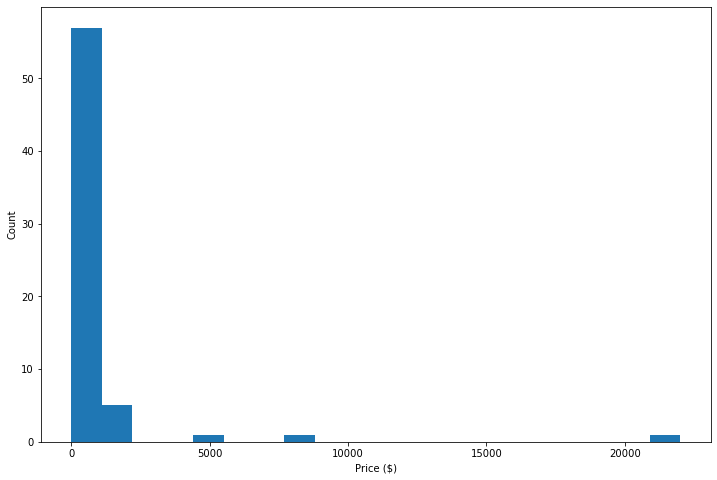

In [64]:
#Visualize distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.hist(results['Price'], bins=20)
plt.xlabel('Price ($)')
plt.ylabel('Count')

# Apartment Listing Scraper

Scrapes and visualized Craigslist apartment listings

In [36]:
# Define apartment scraper function
def ApartmentScraper(url, zip_code='', query_text='', search_distance=''):
    """
    Note: You can either paste the full request url or use the parameters
    query_text = text that you want to search for. e.g. "Subaru"
    zip_code = target zip code for query
    search_distance = search radius in miles for the query e.g. 11.5
    """
    
    if zip_code is not '':
        zip_code = 'postal=' + str(zip_code)
        
    if query_text is not '':
        query_text = '&query=' + str(query_text)
        query_text = query_text.replace(' ', '+')
        
    if search_distance is not '':
        search_distance = '&search_distance=' + str(search_distance)
        
    if zip_code=='' and query_text=='' and search_distance=='':
        full_url = url
#         print('check if true')
    else:
        full_url = url + '?' + zip_code + search_distance + query_text
        
    print('passed url: ', full_url)
        
    response = requests.get(full_url)

    html_soup = bs4.BeautifulSoup(response.text, 'html.parser')            

    # find total number of posts
    results_num = html_soup.find('div', class_ = 'search-legend')
    results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

    print('total results: ', results_total)

    #each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
    pages = np.arange(0, results_total+1, 120)
    print('pages: ', len(pages))
    
    post_titles = []
    post_bedrooms = []
    post_sqft = []
    post_hoods = []
    post_prices = []
    post_dates = []
    post_links = []
    
    for page in pages:

        response = get(full_url + '&s=' + str(page))

        sleep(randint(1,5))

        #throw warning for status codes that are not 200
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))

        #define the html text
        page_html = BeautifulSoup(response.text, 'html.parser')

        #define the posts
        posts = page_html.find_all('li', class_= 'result-row')

        #extract data item-wise
        for post in posts:

            #extract elements from each post soup
            title = post.find('a', class_='result-title hdrlnk')
            title_text = title.text
            
            if post.find('span', class_='result-hood') is not None:
                post_hood = post.find('span', class_= 'result-hood').text
            else:
                post_hood = ''
            
            price = int(post.find('span', class_= 'result-price').text.replace("$","").replace(",",""))
            
            post_time = post.find('time', class_='result-date')
            post_datetime = post_time['datetime']
            
            link = title['href']
            
            # special logic for bedrooms and sqft
            if post.find('span',class_='housing') is not None:
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan                
                
                else:
                    bedroom_count = np.nan
                
                    sqft = np.nan
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                
                sqft = np.nan

            #append results to lists if price greater than 5
            if price > 5:
                post_titles.append(title_text)
                post_prices.append(price)
                post_dates.append(post_datetime)
                post_links.append(link)
                post_hoods.append(post_hood)
                post_bedrooms.append(bedroom_count)
                post_sqft.append(sqft)

    results_df2 = pd.DataFrame({'Title': post_titles,
                                'Neighborhood': post_hoods,
                                'Bedrooms':post_bedrooms,
                                'Sqft':post_sqft,
                                'Price': post_prices,
                                'Date': post_dates,
                                'Link': post_links})

    results_df2 = results_df2.drop_duplicates(subset='Link')
    
    print("Scrape Successful!")

    return results_df2
    

In [49]:
results2 = ApartmentScraper('https://charlottesville.craigslist.org/d/apartments-housing-for-rent/search/apa', 
                            query_text = 'fireplace', 
                            zip_code = '22903', 
                            search_distance = '10')

results2.to_csv("apartment_results.csv", index=False)

passed url:  https://charlottesville.craigslist.org/d/apartments-housing-for-rent/search/apa?postal=22903&search_distance=10&query=fireplace
total results:  427
pages:  4
Scrape Successful!


PermissionError: [Errno 13] Permission denied: 'apartment_results.csv'

In [50]:
results2

,Title,Neighborhood,Bedrooms,Sqft,Price,Date,Link
0,"3 Miles to Downtown, NEW Dog Park, Poolhouse w...",,2,1062.0,1115,2021-02-15 10:54,https://charlottesville.craigslist.org/apa/d/c...
1,"2 Miles to UVA Hospital, Poolhouse with Firepl...",,2,1062.0,1130,2021-02-15 09:37,https://charlottesville.craigslist.org/apa/d/c...
2,"2 Miles to UVA Hospital, Poolhouse with Firepl...",,1,730.0,1106,2021-02-14 21:00,https://charlottesville.craigslist.org/apa/d/c...
3,"Easy Access to City Bus Lines, Poolhouse with ...",,1,730.0,1106,2021-02-13 21:09,https://charlottesville.craigslist.org/apa/d/c...
4,"Poolhouse with Fireplace, 3 Miles to Downtown,...",,1,512.0,995,2021-02-13 15:10,https://charlottesville.craigslist.org/apa/d/c...
...,...,...,...,...,...,...,...
422,1/2 MONTH FREE! LEASE THIS SUNNY 2 BEDROOM END...,(Charlottesville),2,1066.0,1748,2021-01-03 15:02,https://charlottesville.craigslist.org/apa/d/c...
423,NEW YEAR SAVINGS! 1 MONTH FREE! BRIGHT 2 BEDRO...,(Charlottesville),2,1066.0,1708,2021-01-03 14:47,https://charlottesville.craigslist.org/apa/d/c...
424,WELCOME HOME! 2 BEDROOM WITH 1/2 OFF THE 1ST M...,(Charlottesville),2,1114.0,1713,2021-01-03 14:42,https://charlottesville.craigslist.org/apa/d/c...
425,1/2 OFF 1ST MONTH RENT! STUNNING 2 BEDROOM IN ...,(Charlottesville),2,1114.0,1713,2021-01-02 12:13,https://charlottesville.craigslist.org/apa/d/c...


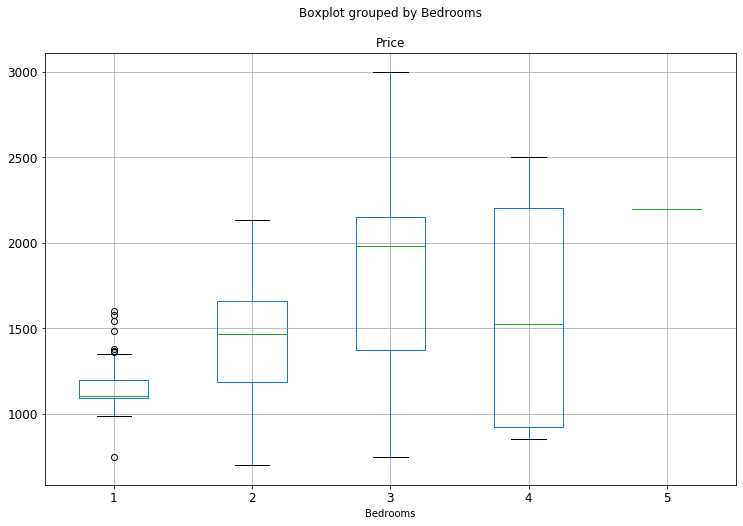

In [51]:
# Visualize results
boxplot = results2.boxplot(column = 'Price', by = 'Bedrooms', figsize = (12,8), fontsize = 12)